In [29]:
inst  <-  suppressMessages(lapply(c('DEP',
                                    'SummarizedExperiment',
                                    'pheatmap',
                                    'ggplot2',
                                    'EnhancedVolcano',
                                    'VennDiagram',
                                    'org.Mm.eg.db',
                                    'clusterProfiler',
                                    'readxl',
                                    'tidyverse',
                                    'KEGGREST'),
                                library,
                                character.only=TRUE)
) 

In [30]:
my_palette = colorRampPalette(c("blue", "white", "red"))(n=255)
options(repr.plot.width=8, repr.plot.height=8)

Set whether anndata objects are recomputed or loaded.

In [31]:
bool_recomp = FALSE

Set whether to produce plots, set to False for test runs.

In [32]:
bool_plot = FALSE

In [33]:
if(bool_recomp){  
    # load the imputed and normalized data from 
    input_file='~/Documents/consultation/Luiza/omics_data/data/astrocyteprotoeme12102017-1.xlsx'
    datraw <- read_excel(input_file, 
                         sheet=2)[,c(4, 3, 11:57)]

    dat <- apply(datraw[,-c(1,2)], 
                 2, 
                 function(x) as.numeric(x)
    )
    gen = as.character(as.matrix(datraw[,1]))

    dat <- aggregate(dat,
                     by=list(gen),
                     FUN=mean,
                     na.rm=TRUE
    )
    rownames(dat) = dat[,1]
    dat = dat[,-1]
    write.csv(dat,'dat.csv', row.names=T)
} else{
    dat=read.csv('dat.csv', row.names=1)
}

## Compare Acsa2 positive vs. negative

### heatmap

In [34]:
if(bool_recomp){ 
    datfin = data.frame(CTX = apply(dat %>% select(ends_with("CTX")), 1, mean),
                        HPT = apply(dat %>% select(ends_with("HPT")), 1, mean),
                        Hippo = apply(dat %>% select(ends_with("Hippo")), 1, mean),
                        CTX_FT = apply(dat %>% select(ends_with("CTX_FT")), 1, mean),
                        HPT_FT = apply(dat %>% select(ends_with("HPT_FT")), 1, mean),
                        Hippo_FT = apply(dat %>% select(ends_with("Hippo_FT")), 1, mean))

    astro = datfin[rownames(datfin)%in%c('Slc1a2', 'Slc1a3', 'Aqp4', 'Gfap', 'Aldh1l1', 'Gja1', 'Gjb6', 'Atp1b2'),]
    neuro = datfin[rownames(datfin)%in%c('Syp', 'Tubb3', 'Snap25', 'Syt1'),]
    mglia = datfin[rownames(datfin)%in%c('Itgam', 'Aif1'),]
    oligo = datfin[rownames(datfin)%in%c('Mog', 'Mag'),]
    endo = datfin[rownames(datfin)%in%c('Slco1c1'),]
    mural = datfin[rownames(datfin)%in%c('Mustn1', 'Pdgfrb', 'Des'),]
    tcyes = datfin[rownames(datfin)%in%c('Crym'),]
    npc = datfin[rownames(datfin)%in%c('Nes', 'Sox2', 'Prom1'),]
    vlmc = datfin[rownames(datfin)%in%c('Col1a1'),]
    mat = as.matrix(rbind(astro, neuro, mglia, oligo, endo, mural)) 
    
    write.csv(mat,'celltype_heatmap.csv', row.names=T)
} else{
    mat=read.csv('celltype_heatmap.csv', row.names=1)
}    

In [7]:
mat = as.matrix(mat)
pheatmap(mat, 
         scale="row",
         show_rownames=F,
         show_colnames=F,
         color=my_palette,
         cluster_cols=F,
         cluster_rows=F, 
         gaps_col=3,
         gaps_row=c(8,12,14,16,17,20),#11, 15, 17, 19, 20, 23),
         fontsize=18,
         legend=T,
         filename="heatmap_ACSA2.pdf",
         width=8,
         height=8
) 

### volcano plot

In [8]:
ft <- read_excel('~/Documents/consultation/Luiza/omics_data/data/astrocyteprotoeme12102017-1.xlsx', 
                 sheet=2)[,c(4, 6 ,10)]
colnames(ft) = c("GeneName", "pvalue", "log2FoldChange")
for (i in 1:nrow(ft)) ft[i,2]=10 ^ -ft[i,2]

In [9]:
pdf(file="SM/volcano_acsa2posVSneg_allgene.pdf", width=10, height=10)
    EnhancedVolcano(ft,
                    lab=ft$GeneName,
                    pCutoff=0.05,
                    x='log2FoldChange',
                    y='pvalue',
                    ylim=c(-0, 25),
                    col=c("grey30", "grey30", "red2", "red2"),
                    title="Acsa2_neg vs. Acsa2_pos"
    )

In [10]:
pdf(file="SM/volcano_acsa2posVSneg_astro.pdf", width=10, height=10)
    EnhancedVolcano(ft,
                    lab=ft$GeneName,
                    pCutoff=0.05,
                    FCcutoff=10,
                    x='log2FoldChange',
                    y='pvalue',
                    ylim=c(-0, 25),
                    selectLab=rownames(mat),
                    labSize=5,
                    labCol='blue',
                    col=c("grey30", "grey30", "red2", "red2"),
                    title="Acsa2_neg vs. Acsa2_pos"
    )

Warning message:
“Removed 2 rows containing missing values (geom_vline).”


In [11]:
dat = dat[,1:24]

## PCA

In [12]:
dat1 <- read.table(file="/Users/viktorian.miok/Documents/data/Protein_Data/proteingroups_astrocytes_imputed.txt",
                   header=T, 
                   sep='\t'
)
dat1 = dat1[-1, c(1:24)]

dat1 <- apply(dat1, 
              2,
              function(x) as.numeric(x)
)
df_pca <- prcomp(t(dat1), 
                 scale=T
)

df_out=as.data.frame(df_pca$x)
df_out$tissue=as.factor(condition = c(rep("Hippo_CD", 4), rep("Hippo_hfd", 4), rep("HPT_CD", 4),
                                      rep("HPT_hfd", 4), rep("CTX_CD", 4), rep("CTX_hfd", 4))
) 

In [13]:
pdf(file="PCA.pdf", width=10, height=10)
    ggplot(df_out, aes(x=PC1, y=PC2, color=tissue)) + 
           geom_point(aes(color=tissue), size=10) + 
           geom_point(shape=1, color="black", size=10) + 
           xlab(paste0("PC1: ",round(df_pca$sdev[1]), "% variance")) + 
           ylab(paste0("PC2: ",round(df_pca$sdev[2]), "% variance")) +
           theme(axis.text=element_text(size=25), 
                 axis.title=element_text(size=30)) + 
           scale_color_manual(values=c("aquamarine4", "aquamarine2", "darkorange2", 
                                       "orange","blueviolet","mediumpurple1")) +
           theme(legend.position="none")
dev.off()

pdf 
  2

## Differential gene expression - diet effect

### volcano

In [14]:
if(bool_recomp){ 
    # load the results from Persus
    hippo = read_excel(input_file, sheet=10)[,c(4, 6, 7)]
    for (i in 1:nrow(hippo)) hippo[i,2]=10 ^ -hippo[i,2]

    ctx = read_excel(input_file, sheet=8)[,c(4, 6, 7)]
    for (i in 1:nrow(ctx)) ctx[i,2]=10 ^ -ctx[i,2]

    hpt = read_excel(input_file, sheet=6)[,c(4, 6, 7)]
    for (i in 1:nrow(hpt)) hpt[i,2]=10 ^ -hpt[i,2]
    
    colnames(hippo) = colnames(ctx) = colnames(hpt) = c("GeneName", "pvalue", "log2FoldChange")
    dge <- list(hpt=hpt,
                hippo=hippo, 
                ctx=ctx
    )
    save(dge, file="dge.RData")
} else {
    load("dge.RData")
}

In [15]:
pdf(file="volcano_hippo.pdf", width=10, height=10)
    EnhancedVolcano(dge[['hippo']],
                    lab=dge[['hippo']]$GeneName,
                    x='log2FoldChange',
                    y='pvalue',
                    FCcutoff=10,
                    pCutoff=0.05,
                    axisLabSize=30,
                    title=NULL,
                    subtitle=NULL,
                    caption=NULL,
                    xlim=c(-5, 5),
                    ylim=c(0, 5),
                    col=c("grey30", "grey30", "red2", "red2"),
                    legendLabels=c('NS', expression(Log[2]~FC), 'p-value>0.05', expression(p-value~and~log[2]~FC)),
                    legendLabSize=30
    )
dev.off()

Warning message:
“Removed 2 rows containing missing values (geom_vline).”


pdf 
  2

In [16]:
pdf(file="volcano_ctx.pdf", width=10, height=10)
    EnhancedVolcano(dge[['ctx']],
                    lab=dge[['ctx']]$GeneName,
                    x='log2FoldChange',
                    y='pvalue',
                    FCcutoff=10,
                    pCutoff=0.05,
                    axisLabSize=30,
                    title=NULL,
                    subtitle=NULL,
                    caption=NULL,
                    xlim=c(-5, 5),
                    ylim=c(0, 5),
                    col=c("grey30", "grey30", "red2", "red2"),
                    legendLabels=c('NS', expression(Log[2]~FC), 'p-value>0.05', expression(p-value~and~log[2]~FC)),
                    legendLabSize=30
   )
dev.off()

Warning message:
“Removed 2 rows containing missing values (geom_vline).”


pdf 
  2

In [17]:
pdf(file="volcano_hpt.pdf", width=10, height=10)
    EnhancedVolcano(dge[['hpt']],
                    lab=dge[['hpt']]$GeneName,
                    x='log2FoldChange',
                    y='pvalue',
                    FCcutoff=10,
                    pCutoff=0.05,
                    axisLabSize=30,
                    title=NULL,
                    subtitle=NULL,
                    caption=NULL,
                    xlim=c(-5, 5),
                    ylim=c(0, 5),
                    col=c("grey30", "grey30", "red2", "red2"),
                    legendLabels=c('NS', expression(Log[2]~FC), 'p-value>0.05', expression(p-value~and~log[2]~FC)),
                    legendLabSize=30)
dev.off()

Warning message:
“Removed 2 rows containing missing values (geom_vline).”


pdf 
  2

In [18]:
pdf(file="SM/Nr_dge_0.05.pdf", width=10, height=10)
    df = data.frame(location=c("Hypothalamus", "Hippocampus", "Cortex"),
                    Sig_genes=c(dim(dge[['hpt']][which(dge[['hpt']][,2]<0.05),])[1], 
                                dim(dge[['hippo']][which(dge[['hippo']][,2]<0.05),])[1],
                                dim(dge[['ctx']][which(dge[['ctx']][,2]<0.05),])[1])
    )
    ggplot(df, aes(x=location, y=Sig_genes, fill=location)) +
           geom_bar(stat="identity") +
           theme(axis.text=element_text(size=20), 
                  axis.title=element_text(size=20), 
                  legend.title=element_text(siz=20),
                  legend.text=element_text(size=20),
                  plot.title=element_text(size=20)) +
           theme(legend.position="none") +
           scale_fill_manual(values=c("lightblue","lightgreen","tan1"))
dev.off()

pdf 
  2

### venn diagram

In [19]:
pdf(file="venn_tran.pdf", width=8, height=8)
vp <- venn.diagram(list(' '=as.matrix(dge[['hpt']][dge[['hpt']][,2]<0.05,1]),
                        ' '=as.matrix(dge[['hippo']][dge[['hippo']][,2]<0.05,1]),
                        ' '=na.omit(as.matrix(dge[['ctx']][dge[['ctx']][,2]<0.05,])[,1])), 
                 fill=c("orange", "mediumpurple1", "aquamarine2"),
                 filename=NULL, 
                 cex=3.5,
                 col="transparent",
                 cat.cex=0.01,
                 margin=0.01,
                 main=NULL,
                 main.cex=3);
    grid.draw(vp)
dev.off()

pdf 
  2

### heatmaps

In [20]:
if(bool_recomp){ 
    datr <- read_excel(input_file,
                       sheet=8)[,c(4,9:16)]
    datctx <- apply(datr[,-1],
                    2,
                    function(x) as.numeric(x)
    )
    gen = as.character(as.matrix(datr[,1]))
    datctx <- aggregate(datctx,by=list(gen),
                        FUN=mean,
                        na.rm=TRUE
    )

    datr <- read_excel(input_file,
                       sheet=10)[,c(4, 9:16)]
    dathip = apply(datr[,-1],
                 2,
                 function(x) as.numeric(x)
    )
    gen = as.character(as.matrix(datr[,1]))
    dathip <- aggregate(dathip,
                        by=list(gen),
                        FUN=mean,
                        na.rm=TRUE
    )

    datr <- read_excel(input_file, 
                       sheet=6)[,c(4,9:16)]
    dathpt <- apply(datr[,-1],
                    2, 
                    function(x) as.numeric(x))
    gen = as.character(as.matrix(datr[,1]))
    dathpt <- aggregate(dathpt,
                        by=list(gen), 
                        FUN=mean, 
                        na.rm=TRUE
    )
                 
    hm <- list(hpt=dathpt, 
               hippo=dathip, 
               ctx=datctx
    )
    save(hm, file="hm.RData")
} else {
    load("hm.RData")
}

In [21]:
rownames(hm[['ctx']]) = hm[['ctx']][,1]
hm[['ctx']] = hm[['ctx']][,-1]
vsd_ctx = hm[['ctx']][rownames(hm[['ctx']])%in%as.character(as.matrix(dge[['ctx']][dge[['ctx']][,2] < 0.05,1])),]

pheatmap(vsd_ctx, 
         scale="row", 
         show_rownames=FALSE,
         show_colnames=FALSE,
         color=my_palette,
         cluster_cols=FALSE, 
         fontsize=15,
         legend=FALSE,
         filename="heatmap_ctx.pdf",
         width=5, 
         height=8,
         breaks=seq(-2, 2, length.out=255)
)

In [22]:
rownames(hm[['hippo']]) = hm[['hippo']][,1]
hm[['hippo']] = hm[['hippo']][,-1]
vsd_hip = hm[['hippo']][rownames(hm[['hippo']])%in%as.character(as.matrix(dge[['hippo']][dge[['hippo']][,2] < 0.05,1])),]

pheatmap(vsd_hip,
         scale="row",
         show_rownames=FALSE,
         show_colnames=FALSE,
         color=my_palette, 
         cluster_cols=FALSE,
         fontsize=15,
         legend=FALSE,
         filename="heatmap_hippo.pdf",
         width=5, 
         height=8,
         breaks=seq(-2, 2, length.out=255)
)

In [23]:
rownames(hm[['hpt']]) = hm[['hpt']][,1]
hm[['hpt']] = hm[['hpt']][,-1]
vsd_hpt = hm[['hpt']][rownames(hm[['hpt']])%in%as.character(as.matrix(dge[['hpt']][dge[['hpt']][,2] < 0.05,1])),]

pheatmap(vsd_hpt,
         scale="row",
         show_rownames=FALSE,
         show_colnames=FALSE,
         color=my_palette,
         cluster_cols=F,
         fontsize=15,
         legend=T,
         filename="heatmap_hpt.pdf",
         width=5, 
         height=8,
         breaks=seq(-2, 2, length.out=255)
) 

## GO - pathway enrichment

In [24]:
if(bool_recomp){
    sg.ctx <- bitr(rownames(vsd_ctx), 
                   fromType="SYMBOL",
                   toType="ENTREZID",
                   OrgDb=org.Mm.eg.db
    )
    go.ctx <- enrichGO(sg.ctx[,2],
                       'org.Mm.eg.db',
                       ont="BP", 
                       pvalueCutoff=0.1
    )
    sg.hpt <- bitr(rownames(vsd_hpt),
                   fromType="SYMBOL",
                   toType="ENTREZID",
                   OrgDb=org.Mm.eg.db
    )
    go.hpt <- enrichGO(sg.hpt[,2],
                       'org.Mm.eg.db', 
                       ont="BP",
                       pvalueCutoff=0.1
    )
    sg.hip <- bitr(rownames(vsd_hip),
                   fromType="SYMBOL",
                   toType="ENTREZID",
                   OrgDb=org.Mm.eg.db
    )
    go.hip <- enrichGO(sg.hip[,2],
                       'org.Mm.eg.db',
                       ont="BP", 
                       pvalueCutoff=0.1
    )
    go = c("insulin receptor signaling pathway",
           "leptin-mediated signaling pathway",
           "response to leptin",
           "glycolytic process",
           "cellular response to glucose stimulus",
           "cellular carbohydrate metabolic process",
           "glycogen metabolic process",
           "glucose transmembrane transport",
           "fatty acid catabolic process",
           "lipid import into cell",
           "response to endoplasmic reticulum stress",
           "response to reactive oxygen species",
           "response to oxidative stress",
           "positive regulation of G1/S transition of mitotic cell cycle",
           #"glial cell proliferation",
           "microtubule cytoskeleton organization involved in mitosis",
           "smoothened signaling pathway",
           "positive regulation of inflammatory response",
           "cell-substrate junction assembly",
           "regulation of cell shape",
           "calcium ion transport into cytosol",
           "calcium-mediated signaling",
           "axon guidance",
           "regulation of neurotransmitter levels",
           "glutamate receptor signaling pathway",
           "axonogenesis",
           "regulation of synaptic transmission, dopaminergic",
           "regulation of neuronal synaptic plasticity"
    )
    enr_ctx.go = go.ctx@result[go.ctx@result[,5]<0.05, c(2, 5, 6, 8, 9)]
    enr_ctx.go$Tissue = 'CTX'
    enr_hpt.go = go.hpt@result[go.hpt@result[,5]<0.05, c(2, 5, 6, 8, 9)]
    enr_hpt.go$Tissue = 'HPT'
    enr_hip.go = go.hip@result[go.hip@result[,5]<0.05, c(2, 5, 6, 8, 9)]
    enr_hip.go$Tissue = 'Hippo'
    
    all <- rbind(enr_ctx.go, enr_hpt.go, enr_hip.go)
    write.csv(all, file="GO_proteome.csv")
    all <- all[all$Description%in%go,]
    colnames(all) = c('Description', 'pvalue', 'p.adjust', 'geneID', 'count', 'Tissue')
    
    all = rbind(enr_ctx.go, enr_hpt.go, enr_hip.go)
    all1 = all[all$Description%in%go,]
    
    sig.gene.hpt.all <- bitr(dge[['hpt']]$GeneName,
                             fromType="SYMBOL",
                             toType="ENTREZID",
                             OrgDb=org.Mm.eg.db
    )
    sig.gene.ctx.all <- bitr(dge[['ctx']]$GeneName, 
                             fromType="SYMBOL", 
                             toType="ENTREZID", 
                             OrgDb=org.Mm.eg.db
    )
    sig.gene.hip.all <- bitr(dge[['hippo']]$GeneName,
                             fromType="SYMBOL",
                             toType="ENTREZID",
                             OrgDb=org.Mm.eg.db
    )
    # CTX
    df_total.ctx = data.frame()
    for(i in 1:nrow(all1)){   
        p = as.data.frame(dge[['ctx']][which(dge[['ctx']]$GeneName%in%
                          sig.gene.ctx.all[sig.gene.ctx.all[,2]%in%unlist(strsplit(all1$geneID[i],"/")),1]), c(2,3)])
        p$pathway = all1$Description[i]
        p$padjPath = all1$p.adjust[i]
        p$count = all1$Count[i]
        df_total.ctx = rbind(df_total.ctx, p)    
    }
    df_total.ctx$significance <- ifelse(df_total.ctx$pvalue<0.05,
                                        "significant",
                                        "not significant"
    )
    # HPT
    df_total.hpt=data.frame()
    for(i in 1:nrow(all1)){
        p = as.data.frame(dge[['hpt']][which(dge[['hpt']]$GeneName%in%
                          sig.gene.hpt.all[sig.gene.hpt.all[,2]%in%unlist(strsplit(all1$geneID[i],"/")),1]), c(2,3)])
        p$pathway = all1$Description[i]
        p$tissue = all1$Tissue[i]
        p$padjPath = all1$pvalue[i]
        p$count = all1$Count[i]
        df_total.hpt = rbind(df_total.hpt, p)    
    } 
    for(j in 1:nrow(df_total.hpt)) {if((df_total.hpt$tissue[j]=='HPT')&(df_total.hpt$pvalue[j] > 0.05)) df_total.hpt$pvalue[j]<-0.05}
    df_total.hpt$significance <- ifelse(df_total.hpt$pvalue <= 0.05,
                                        "significant",
                                        "not significant"
    )
    # Hippo
    df_total.hip = data.frame()
    for(i in 1:nrow(all1)){
        p = as.data.frame(dge[['hippo']][which(dge[['hippo']]$GeneName%in%
                        sig.gene.hip.all[sig.gene.hip.all[,2]%in%unlist(strsplit(all1$geneID[i],"/")),1]),c(2,3)])
        p$pathway = all1$Description[i]
        p$padjPath = all1$p.adjust[i]
        p$count = all1$Count[i]
        df_total.hip = rbind(df_total.hip,p)    
    }    
    df_total.hip$col <- ifelse(df_total.hip$pvalue<=0.05,
                               "red",
                               "grey"
    )
    gsea <- list(all=all1,
                 ctx=df_total.ctx,
                 hpt=df_total.hpt,
                 hippo=df_total.hip,
                 go=go
    )
    save(gsea, file="gsea.RData")
} else {
    load("gsea.RData")
}

In [25]:
pdf(file="enrich_path.pdf", width=15, height=15)
    ggplot(gsea[['all']],   # 
           aes(Tissue, y=factor(Description, level=gsea[['go']][length(gsea[['go']]):1]), col=pvalue, size=Count)) + 
           geom_point() + 
           scale_colour_gradient(low="red", high="blue") +
           scale_size_continuous(range=c(3, 10)) +
           xlab("") + 
           ylab("") + 
           theme(axis.text.x=element_blank()) + 
           theme(legend.position="none") +
           theme(text=element_text(size=40))
dev.off()

pdf 
  2

In [26]:
pdf(file="enrichdot_ctx.pdf", width=7, height=15)
    ggplot(gsea[['ctx']], aes(log2FoldChange, y=factor(pathway, level=gsea[['go']][length(gsea[['go']]):1]))) + 
           geom_point(aes(colour=significance, size=-log10(pvalue)), alpha=0.5) + 
           scale_color_manual(values=c("gray85", "red")) + 
           scale_size_continuous(range=c(0, 7.5)) +  #
           geom_vline(xintercept=0) +
           theme(axis.title=element_text(size=20),
                 title=element_text(size=20), 
                 text = element_text(size=35)) + #guides(color=guide_legend(override.aes=list(size=5) ) ) +
           theme(legend.position="none") + 
           theme(axis.text.y=element_blank()) + 
           ylab("") +
           xlab("") + 
           xlim(-2.68, 3.82)
dev.off()

pdf 
  2

In [27]:
pdf(file="enrichdot_hpt.pdf", width=7, height=15)
    ggplot(gsea[['hpt']], aes(log2FoldChange, y=factor(pathway, level=gsea[['go']][length(gsea[['go']]):1]))) + 
           geom_point(aes(colour=significance, size= -log10(pvalue)), alpha=0.5) + 
           scale_color_manual(values=c("gray85", "red")) + 
           scale_size_continuous(range=c(0, 8.5)) +  #
           geom_vline(xintercept=0) +
           theme(axis.title=element_text(size=20),
                 title=element_text(size=20), 
                 text=element_text(size=35)) + 
           theme(legend.position="none") + 
           theme(axis.text.y=element_blank()) + 
           ylab("") +
           xlab("") + 
           xlim(-2.68, 3.82)
dev.off()

pdf 
  2

In [28]:
pdf(file="enrichdot_hippo.pdf", width=7, height=15)

    ggplot(gsea[['hippo']], aes(log2FoldChange, y=factor(pathway, level=gsea[['go']][length(gsea[['go']]):1]))) + 
           geom_point(aes(colour=col, size=-log10(pvalue)), alpha=0.5) + 
           scale_color_manual(values=c("gray85", "red"))+ 
           scale_size_continuous(range = c(0, 7.5)) +
           geom_vline(xintercept=0) +
           theme(axis.title=element_text(size=20),
                 title=element_text(size=20), 
                 text = element_text(size=35)) +
           theme(legend.position="none") + 
           theme(axis.text.y=element_blank()) + 
           ylab("") + 
           xlab("") + 
           xlim(-2.68, 3.82)
dev.off()

pdf 
  2

## Heatmap microglia genes

In [39]:
datfin = data.frame(CTX_chow = apply(dat %>% select(ends_with("CTX") & starts_with("Chow")), 1, mean),
                    CTX_hfd = apply(dat %>% select(ends_with("CTX") & starts_with("HFD")), 1, mean),
                    HPT_chow = apply(dat %>% select(ends_with("HPT") & starts_with("Chow")), 1, mean),
                    HPT_hfd = apply(dat %>% select(ends_with("HPT") & starts_with("HFD")), 1, mean),
                    Hippo_chow = apply(dat %>% select(ends_with("Hippo") & starts_with("Chow")), 1, mean),
                    Hippo_hfd = apply(dat %>% select(ends_with("Hippo") & starts_with("HFD")), 1, mean))


pan = datfin[rownames(datfin)%in%c('Lcn2','Steap4','S1pr3','Timp1','Hsbp1','Cxcl10','Cd44',
                                   'Osmr','Cp','Serpina3n','Aspg','Vim','Gfap'),]
a1 = datfin[rownames(datfin)%in%c('Serping1','H2-D1','Ggta1','Iigp1','Gbp2','Fbln5','Fkbp5','Psmb8',
                                  'Srgn','Amigo2','C3','H2-T23'),]
a2 = datfin[rownames(datfin)%in%c('Clcf1','Tgm1','Ptx3','S100a10','Sphk1','Cd109','Ptgs2',
                                  'Emp1','Slc10a6','Tm4sf1','B3gnt5','Cd14','Stat3'),]

pan = pan[order(row.names(pan)),]
a1 = a1[order(row.names(a1)),]
a2 = a2[order(row.names(a2)),]
mat = rbind(pan, a1, a2)    

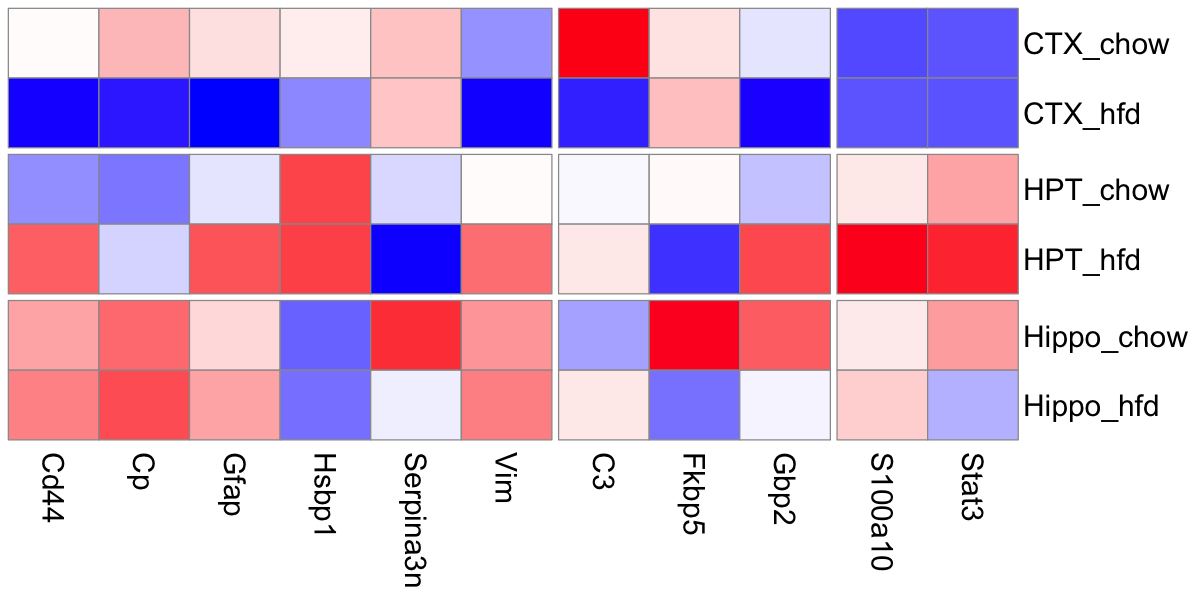

In [44]:
options(repr.plot.width=10, repr.plot.height=5)
mat1 = as.matrix(t(mat))
pheatmap(mat1, 
         scale="column",
         show_rownames=T, 
         show_colnames=T,
         color=my_palette, 
         cluster_cols=F,
         cluster_rows=F, 
         gaps_col=c(6,9),
         gaps_row=c(2,4,6), 
         fontsize=18,
         #filename="heatmap_ACSA2.pdf",
         legend=F,
         width=5, 
         height=8
) 